In [1]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sn
import sqlite3
import matplotlib.pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from gensim.models import Word2Vec

In [2]:
con = sqlite3.connect('./final_review_data_set.db')
review_data = pd.read_sql_query("select * from Review",con)

review_data.shape , display(review_data.head()) , review_data.isna().any()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",junei saw charming groupof roses beginto droop...
1,1,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,fun way children learn months year learn poems...
2,2,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",grew reading sendak books watching really rosi...
3,3,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,get movie sound track sing along carol king gr...
4,4,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,entertaining rhyming story cleaver catchy illu...


((393931, 11),
 None,
 index                     False
 Id                        False
 ProductId                 False
 UserId                    False
 ProfileName               False
 HelpfulnessNumerator      False
 HelpfulnessDenominator    False
 Score                     False
 Time                      False
 Summary                   False
 Text                      False
 dtype: bool)

In [3]:
review_data = review_data.sample(80000)

In [4]:
X_data = review_data.drop(['Score'],axis=1)
y_data = review_data['Score']

In [5]:
count_vect = CountVectorizer(min_df=0.01)
X_bow = count_vect.fit_transform(X_data['Text'].values)
X_bow

<80000x634 sparse matrix of type '<class 'numpy.int64'>'
	with 1596207 stored elements in Compressed Sparse Row format>

In [6]:
#applying fit transform on train datasset
tf_idf_vect = TfidfVectorizer(min_df=0.01)
x_tfidf = tf_idf_vect.fit_transform(X_data['Text'].values)

In [7]:
textsplits = [text.split() for text in X_data['Text'].values]
len(textsplits)

80000

In [8]:
w2v_model = Word2Vec(textsplits,min_count=10,vector_size=65)
X_w2v = w2v_model.wv.key_to_index.keys()


In [9]:
w2v_words = list(X_w2v)
list_vectors = []

for text in tqdm(textsplits):
    count_words = 0
    text_vec = np.zeros(65)
    
    for w in text:

        if w in w2v_words:
            count_words += 1
            vec = w2v_model.wv[w]
            text_vec += vec

    if count_words != 0:
        text_vec /= count_words

    list_vectors.append(text_vec)

print(len(list_vectors))
print(len(list_vectors[0]))



100%|██████████| 80000/80000 [01:08<00:00, 1173.58it/s]

80000
65


In [10]:
X_w2v = np.array(list_vectors)
X_w2v.shape

(80000, 65)

In [11]:
# tfidf - word2vec
tf_idf_model = TfidfVectorizer()
tf_idf_matrix = tf_idf_model.fit_transform(X_data['Text'].values)
mapped_data = dict(zip(tf_idf_model.get_feature_names_out(), list(tf_idf_model.idf_)))
# mapped_data

In [12]:
# TF-IDF weighted Word2Vec

tfidf_text_vectors = []

for text in tqdm(textsplits):
    weight_sum = 0 
    text_vec = np.zeros(65)

    for w in text: 
        if w in w2v_words and len(w) != 1:
            vec = w2v_model.wv[w]
            data = mapped_data[w]*(text.count(w)/len(text))
            text_vec += (vec * data)
            weight_sum += data

    if weight_sum != 0:
        text_vec /= weight_sum
        
    tfidf_text_vectors.append(text_vec)


100%|██████████| 80000/80000 [01:19<00:00, 1006.10it/s]


In [13]:
X_tfw2v = np.array(tfidf_text_vectors)


In [14]:
# BOW
# Simple Cross Validation

In [15]:
X_bow_sample = X_bow[:80000]
y_bow_sample = y_data[:80000]

In [16]:
y_bow_sample.value_counts()

Score
1    68426
0    11574
Name: count, dtype: int64

In [17]:
# split the dataset
X_train_bow_sample, X_test_bow_sample, y_train_bow_sample, y_test_bow_sample = train_test_split(
    X_bow_sample, y_bow_sample, test_size=0.25, random_state=234)

In [18]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_bow_sample, y_train_bow_sample, test_size=0.3)

f1_scores=[]
myList = list(range(30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr[:30000], y_tr[:30000])

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label=1, average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test_bow_sample)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_bow_sample, pred, pos_label=1, average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_bow_sample, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.866918

CV f1-score for k = 3 is 0.905017

CV f1-score for k = 5 is 0.914939

CV f1-score for k = 7 is 0.919227

CV f1-score for k = 9 is 0.922166

CV f1-score for k = 11 is 0.922595

CV f1-score for k = 13 is 0.923114

CV f1-score for k = 15 is 0.923396

CV f1-score for k = 17 is 0.923742

CV f1-score for k = 19 is 0.923806

CV f1-score for k = 21 is 0.923768

CV f1-score for k = 23 is 0.923496

CV f1-score for k = 25 is 0.923510

CV f1-score for k = 27 is 0.923501

CV f1-score for k = 29 is 0.923611

The optimal number of neighbors is 19.

****Test f1-score for k = 19 is 0.920129****

****Test accuracy for k = 19 is 85.285000%****


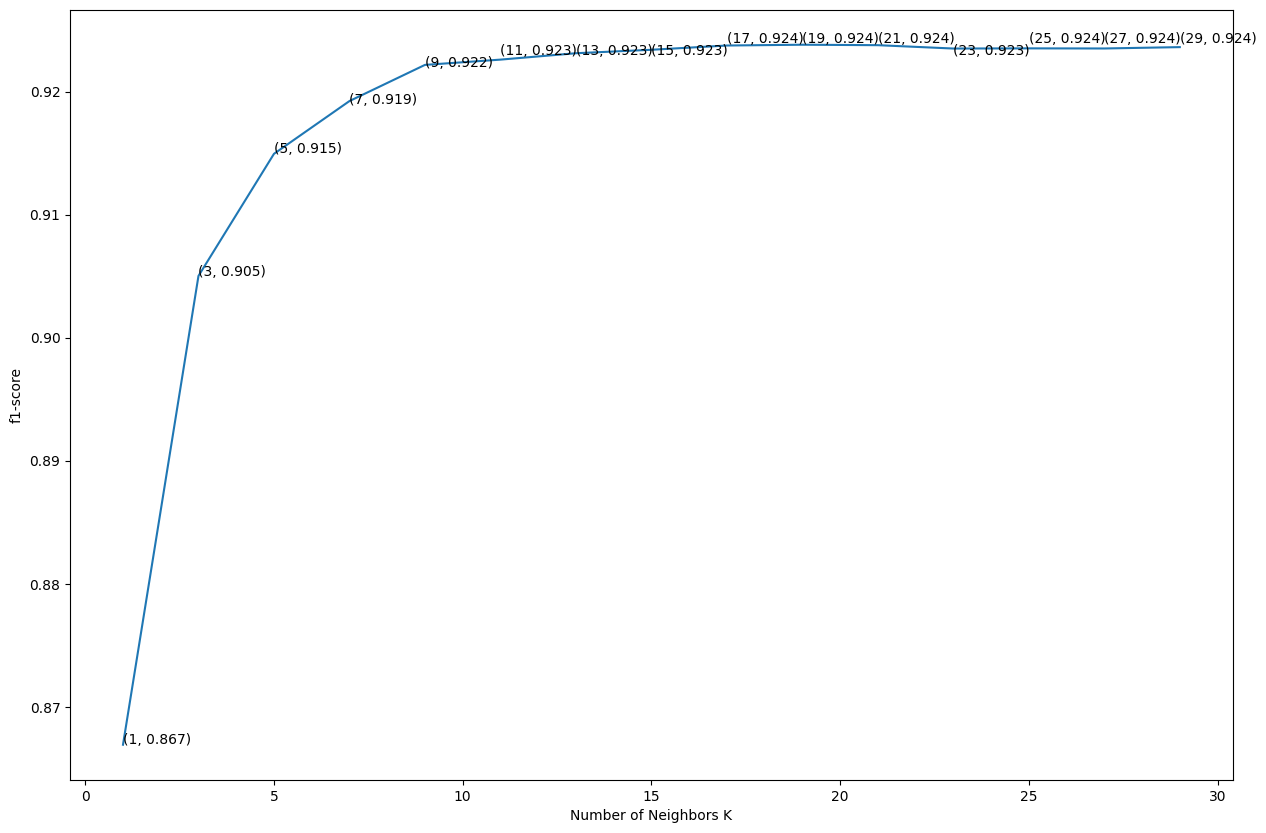

The f1-score for each k value is :  [0.86692 0.90502 0.91494 0.91923 0.92217 0.9226  0.92311 0.9234  0.92374
 0.92381 0.92377 0.9235  0.92351 0.9235  0.92361]


In [19]:
# plot f1-score vs k 
plt.figure(figsize=(15,10))
plt.plot(neighbors, f1_scores)
for xy in zip(neighbors, np.round(f1_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1-score')
plt.show()

print("The f1-score for each k value is : ", np.round(f1_scores,5))

In [20]:
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_bow_sample, y_train_bow_sample, test_size=0.25)
f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr[:20000], y_tr[:20000])

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label=1, average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test_bow_sample.toarray())
#determining the Test f1 score for optimal k
f1 = f1_score(y_test_bow_sample, pred, pos_label=1, average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))
#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_bow_sample, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 1 is 0.882172


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 3 is 0.908990


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 5 is 0.913971


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 7 is 0.919212


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 9 is 0.921072


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 11 is 0.921710


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 13 is 0.922139


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 15 is 0.922351


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 17 is 0.922402


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 19 is 0.922590


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 21 is 0.922800


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 23 is 0.922823


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 25 is 0.922922


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 27 is 0.922756


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 29 is 0.922767

The optimal number of neighbors is 25.

****Test f1-score for k = 25 is 0.919464****

****Test accuracy for k = 25 is 85.135000%****


In [21]:
#computing confusion matrix
cm = confusion_matrix(y_test_bow_sample, pred)
print(cm)

[[   56  2950]
 [   23 16971]]


<Axes: >

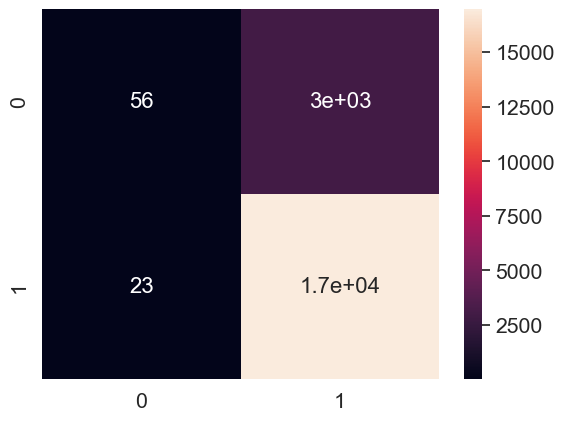

In [22]:
#plotting confusion matrix as heatmap
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}) 

In [29]:
## Simple Cross Validation with TFIDF

In [23]:
X_tfidf_sample = x_tfidf[:80000]
y_tfidf_sample = y_data[:80000]

In [24]:
# split the dataset
X_train_tfidf_sample, X_test_tfidf_sample, y_train_tfidf_sample, y_test_tfidf_sample = train_test_split(
    X_tfidf_sample, y_tfidf_sample, test_size=0.25, random_state=234)

In [25]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_tfidf_sample, y_train_tfidf_sample, test_size=0.25)

f1_scores=[]
myList = list(range(30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr[:20000], y_tr[:20000])

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label=1, average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test_tfidf_sample)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_tfidf_sample, pred, pos_label=1, average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_tfidf_sample, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.438608

CV f1-score for k = 3 is 0.911005

CV f1-score for k = 5 is 0.919263

CV f1-score for k = 7 is 0.920664

CV f1-score for k = 9 is 0.920750

CV f1-score for k = 11 is 0.920917

CV f1-score for k = 13 is 0.920951

CV f1-score for k = 15 is 0.920924

CV f1-score for k = 17 is 0.920824

CV f1-score for k = 19 is 0.920863

CV f1-score for k = 21 is 0.920863

CV f1-score for k = 23 is 0.920863

CV f1-score for k = 25 is 0.920863

CV f1-score for k = 27 is 0.920863

CV f1-score for k = 29 is 0.920863

The optimal number of neighbors is 13.

****Test f1-score for k = 13 is 0.918852****

****Test accuracy for k = 13 is 85.005000%****


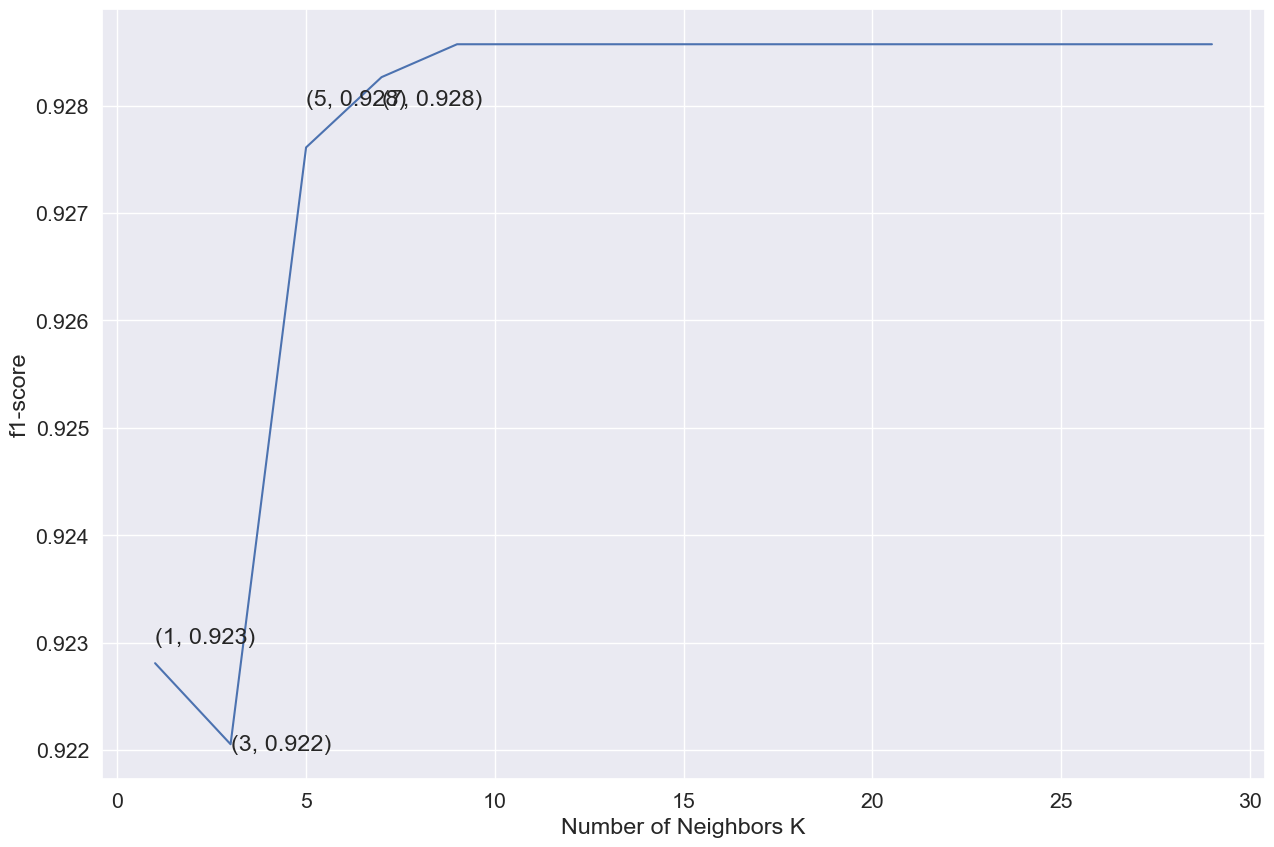

The f1-score for each k value is :  [0.92281 0.92206 0.92761 0.92827 0.92857 0.92857 0.92857 0.92857 0.92857
 0.92857 0.92857 0.92857 0.92857 0.92857 0.92857]


In [ ]:
# plot f1-score vs k 
plt.figure(figsize=(15,10))
plt.plot(neighbors, f1_scores)
for xy in zip(neighbors, np.round(f1_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1-score')
plt.show()

print("The f1-score for each k value is : ", np.round(f1_scores,5))

In [27]:
#KD - Tree
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_tfidf_sample, y_train_tfidf_sample, test_size=0.25)
f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr[:20000], y_tr[:20000])

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label=1, average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test_tfidf_sample.toarray())
#determining the Test f1 score for optimal k
f1 = f1_score(y_test_tfidf_sample, pred, pos_label=1, average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))
#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_tfidf_sample, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 1 is 0.909272


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 3 is 0.920094


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 5 is 0.922451


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 7 is 0.922684


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 9 is 0.922856


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 11 is 0.923105


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 13 is 0.923099


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 15 is 0.923105


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 17 is 0.923105


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 19 is 0.923071


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 21 is 0.923071


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 23 is 0.923071


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 25 is 0.923071


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 27 is 0.923071


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



CV f1-score for k = 29 is 0.923071

The optimal number of neighbors is 11.

****Test f1-score for k = 11 is 0.918770****

****Test accuracy for k = 11 is 85.000000%****


In [28]:
#computing confusion matrix
cm = confusion_matrix(y_test_tfidf_sample, pred)
print(cm)

[[   34  2972]
 [   28 16966]]


<Axes: >

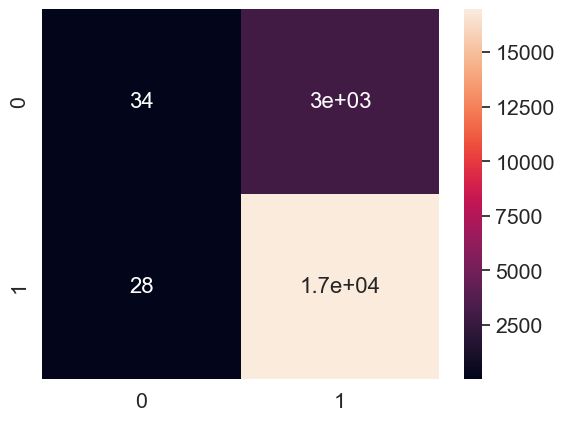

In [29]:
#plotting confusion matrix as heatmap
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}) 

In [30]:
#AVG Word2Vec
# Simple Cross Validation

In [31]:
X_w2v_sample = X_w2v[:80000]
y_w2v_sample = y_data[:80000]

In [32]:
# split the dataset
X_train_w2v_sample, X_test_w2v_sample, y_train_w2v_sample, y_test_w2v_sample = train_test_split(
    X_w2v_sample, y_w2v_sample, test_size=0.25, random_state=234)

In [33]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_w2v_sample, y_train_w2v_sample, test_size=0.25)

f1_scores=[]
myList = list(range(30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr[:20000], y_tr[:20000])

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label=1, average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test_w2v_sample)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_w2v_sample, pred, pos_label=1, average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_w2v_sample, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.902699

CV f1-score for k = 3 is 0.921107

CV f1-score for k = 5 is 0.926884

CV f1-score for k = 7 is 0.928447

CV f1-score for k = 9 is 0.929338

CV f1-score for k = 11 is 0.928863

CV f1-score for k = 13 is 0.929711

CV f1-score for k = 15 is 0.929633

CV f1-score for k = 17 is 0.929250

CV f1-score for k = 19 is 0.928833

CV f1-score for k = 21 is 0.928922

CV f1-score for k = 23 is 0.929392

CV f1-score for k = 25 is 0.929143

CV f1-score for k = 27 is 0.929117

CV f1-score for k = 29 is 0.928681

The optimal number of neighbors is 13.

****Test f1-score for k = 13 is 0.926791****

****Test accuracy for k = 13 is 86.810000%****


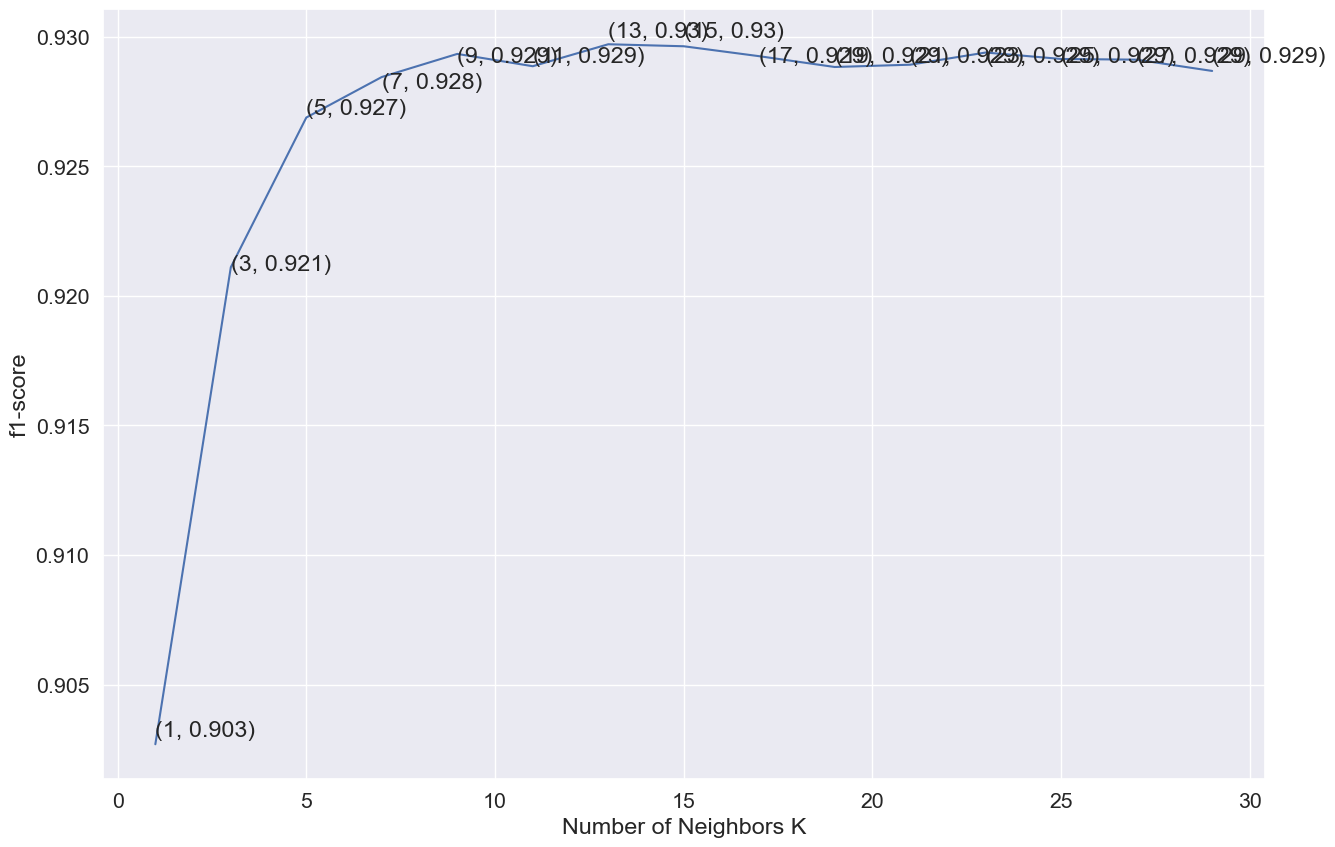

The f1-score for each k value is :  [0.9027  0.92111 0.92688 0.92845 0.92934 0.92886 0.92971 0.92963 0.92925
 0.92883 0.92892 0.92939 0.92914 0.92912 0.92868]


In [34]:
# plot f1-score vs k 
plt.figure(figsize=(15,10))
plt.plot(neighbors, f1_scores)
for xy in zip(neighbors, np.round(f1_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1-score')
plt.show()

print("The f1-score for each k value is : ", np.round(f1_scores,5))

In [35]:
#KD - Tree
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_w2v_sample, y_train_w2v_sample, test_size=0.25)
f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr[:20000], y_tr[:20000])

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label=1, average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test_w2v_sample)
#determining the Test f1 score for optimal k
f1 = f1_score(y_test_w2v_sample, pred, pos_label=1, average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))
#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_w2v_sample, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.901311

CV f1-score for k = 3 is 0.920116

CV f1-score for k = 5 is 0.925750

CV f1-score for k = 7 is 0.928711

CV f1-score for k = 9 is 0.929480

CV f1-score for k = 11 is 0.930152

CV f1-score for k = 13 is 0.930461

CV f1-score for k = 15 is 0.930660

CV f1-score for k = 17 is 0.929774

CV f1-score for k = 19 is 0.930471

CV f1-score for k = 21 is 0.930448

CV f1-score for k = 23 is 0.929937

CV f1-score for k = 25 is 0.930041

CV f1-score for k = 27 is 0.929883

CV f1-score for k = 29 is 0.930046

The optimal number of neighbors is 15.

****Test f1-score for k = 15 is 0.927043****

****Test accuracy for k = 15 is 86.840000%****


In [36]:
#computing confusion matrix
cm = confusion_matrix(y_test_tfidf_sample, pred)
print(cm)

[[  646  2360]
 [  272 16722]]


<Axes: >

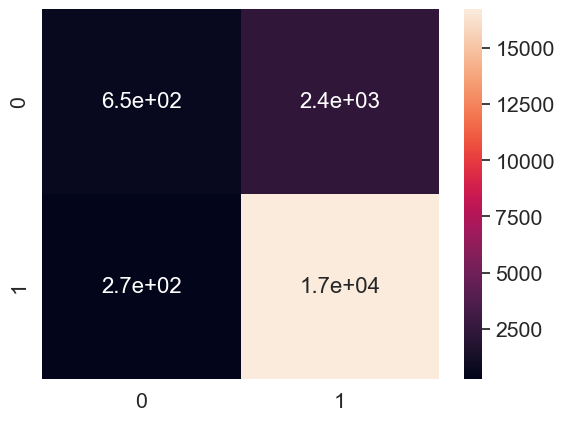

In [37]:
#plotting confusion matrix as heatmap
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}) 

In [38]:
# TF-IDF Word2Vec

In [39]:
X_tfw2v_sample = X_tfw2v[:80000]
y_tfw2v_sample = y_data[:80000]

In [40]:
# split the dataset
X_train_tfw2v_sample, X_test_tfw2v_sample, y_train_tfw2v_sample, y_test_tfw2v_sample = train_test_split(
    X_tfw2v_sample, y_tfw2v_sample, test_size=0.25, random_state=234)

In [41]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_tfw2v_sample, y_train_tfw2v_sample, test_size=0.25)

f1_scores=[]
myList = list(range(30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr[:20000], y_tr[:20000])

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label=1, average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test_tfw2v_sample)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_tfw2v_sample, pred, pos_label=1, average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_tfw2v_sample, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.889673

CV f1-score for k = 3 is 0.912829

CV f1-score for k = 5 is 0.921744

CV f1-score for k = 7 is 0.925247

CV f1-score for k = 9 is 0.925976

CV f1-score for k = 11 is 0.927135

CV f1-score for k = 13 is 0.927187

CV f1-score for k = 15 is 0.927379

CV f1-score for k = 17 is 0.927691

CV f1-score for k = 19 is 0.928277

CV f1-score for k = 21 is 0.928524

CV f1-score for k = 23 is 0.928238

CV f1-score for k = 25 is 0.928308

CV f1-score for k = 27 is 0.928709

CV f1-score for k = 29 is 0.928558

The optimal number of neighbors is 27.

****Test f1-score for k = 27 is 0.924977****

****Test accuracy for k = 27 is 86.360000%****


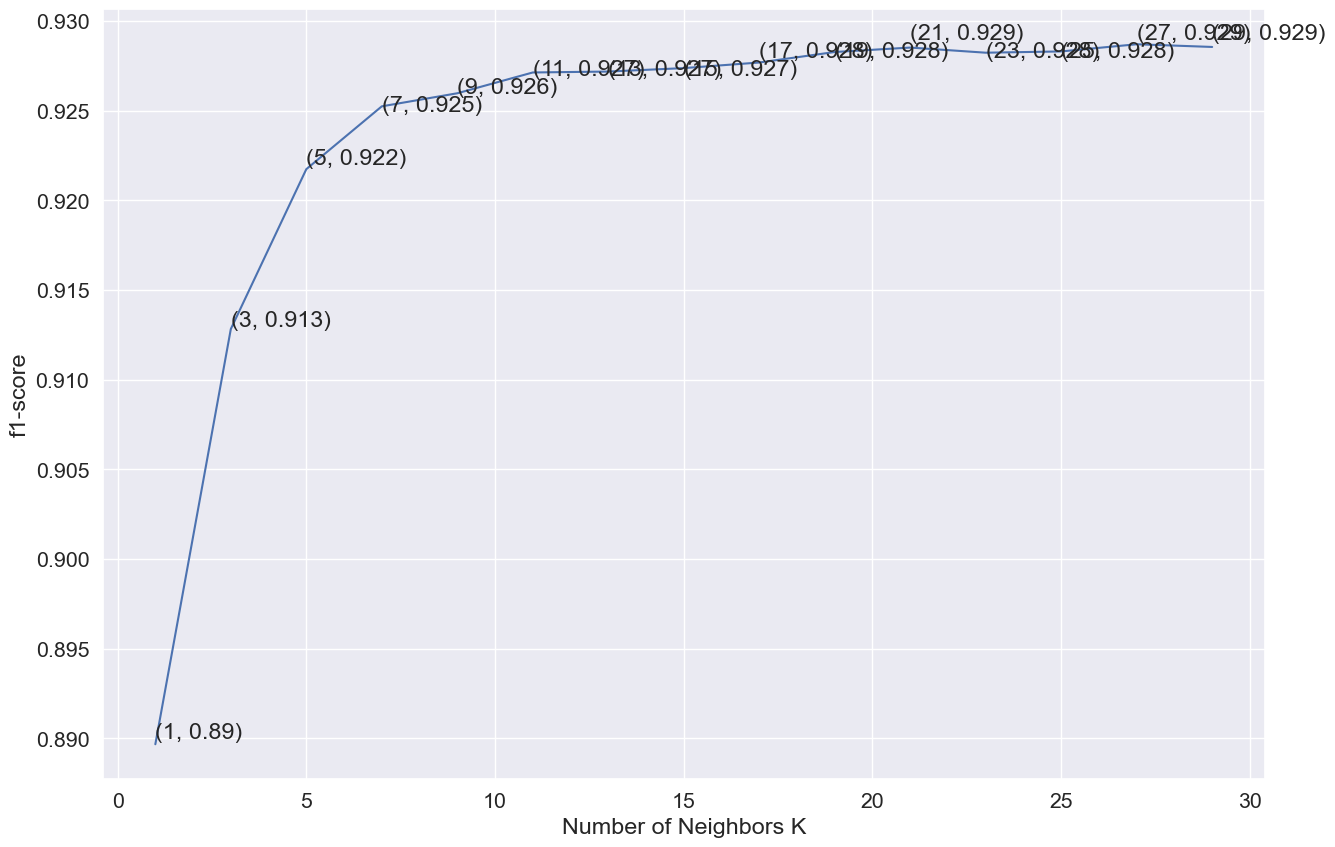

The f1-score for each k value is :  [0.88967 0.91283 0.92174 0.92525 0.92598 0.92714 0.92719 0.92738 0.92769
 0.92828 0.92852 0.92824 0.92831 0.92871 0.92856]


In [42]:
# plot f1-score vs k 
plt.figure(figsize=(15,10))
plt.plot(neighbors, f1_scores)
for xy in zip(neighbors, np.round(f1_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1-score')
plt.show()

print("The f1-score for each k value is : ", np.round(f1_scores,5))

In [43]:
#KD - Tree
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_tfw2v_sample, y_train_tfw2v_sample, test_size=0.25)
f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr[:20000], y_tr[:20000])

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label=1, average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test_tfw2v_sample)
#determining the Test f1 score for optimal k
f1 = f1_score(y_test_tfw2v_sample, pred, pos_label=1, average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))
#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_tfw2v_sample, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.892480

CV f1-score for k = 3 is 0.915035

CV f1-score for k = 5 is 0.922786

CV f1-score for k = 7 is 0.926095

CV f1-score for k = 9 is 0.927277

CV f1-score for k = 11 is 0.928085

CV f1-score for k = 13 is 0.928788

CV f1-score for k = 15 is 0.928592

CV f1-score for k = 17 is 0.928459

CV f1-score for k = 19 is 0.927918

CV f1-score for k = 21 is 0.928278

CV f1-score for k = 23 is 0.928431

CV f1-score for k = 25 is 0.928260

CV f1-score for k = 27 is 0.928195

CV f1-score for k = 29 is 0.928535

The optimal number of neighbors is 13.

****Test f1-score for k = 13 is 0.925486****

****Test accuracy for k = 13 is 86.555000%****


In [44]:
#computing confusion matrix
cm = confusion_matrix(y_test_tfidf_sample, pred)
print(cm)

[[  612  2394]
 [  295 16699]]


<Axes: >

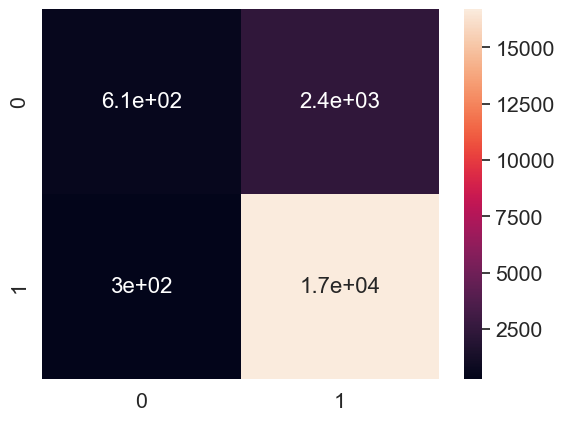

In [45]:
#plotting confusion matrix as heatmap
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}) 